In [1]:
import os
import pandas as pd
#import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import time
from testWN import testWN as twm
import wntr
import wntr.network.controls as controls
import wntr.metrics.economic as economics
import pdb
import pickle
import random

In [2]:
%matplotlib notebook

# Water Network data loading

/Applications/anaconda3/lib/python3.7/site-packages/wntr/epanet/io.py:2085: UserWarning: Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


<IPython.core.display.Javascript object>


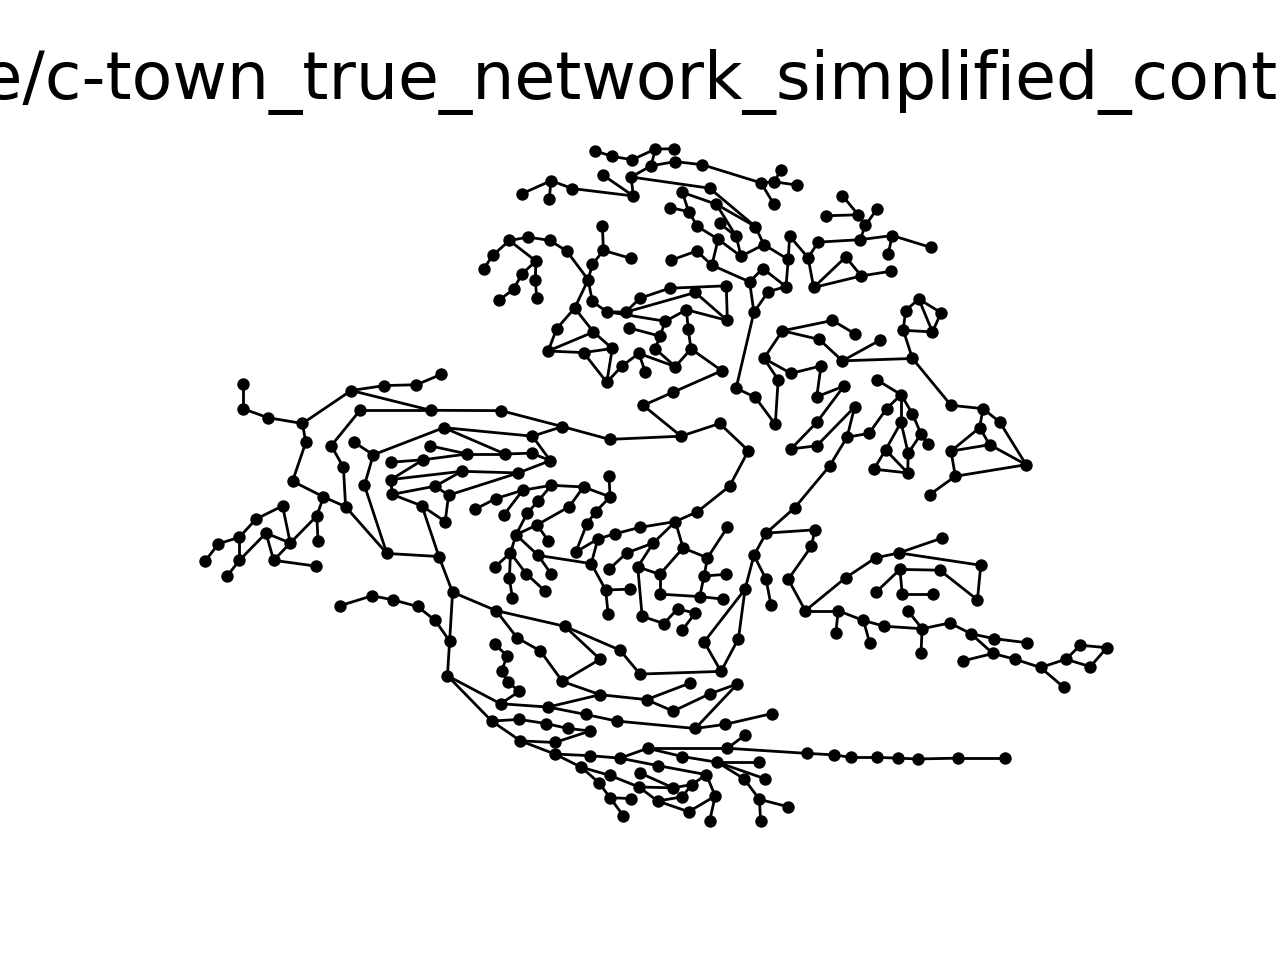

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [3]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'

ctown = twm(inp_file)

# plt.figure()

# %%
# Graphical representation of the network
plt.rcParams.update({'font.size': 20})
wntr.graphics.plot_network(ctown.wn, title=ctown.wn.name, node_labels=False, link_labels=False, directed=False)
fig = mpl.pyplot.gcf()
mpl.rcParams.update(mpl.rcParamsDefault)

plt.show()

# Modify demand patterns

<IPython.core.display.Javascript object>


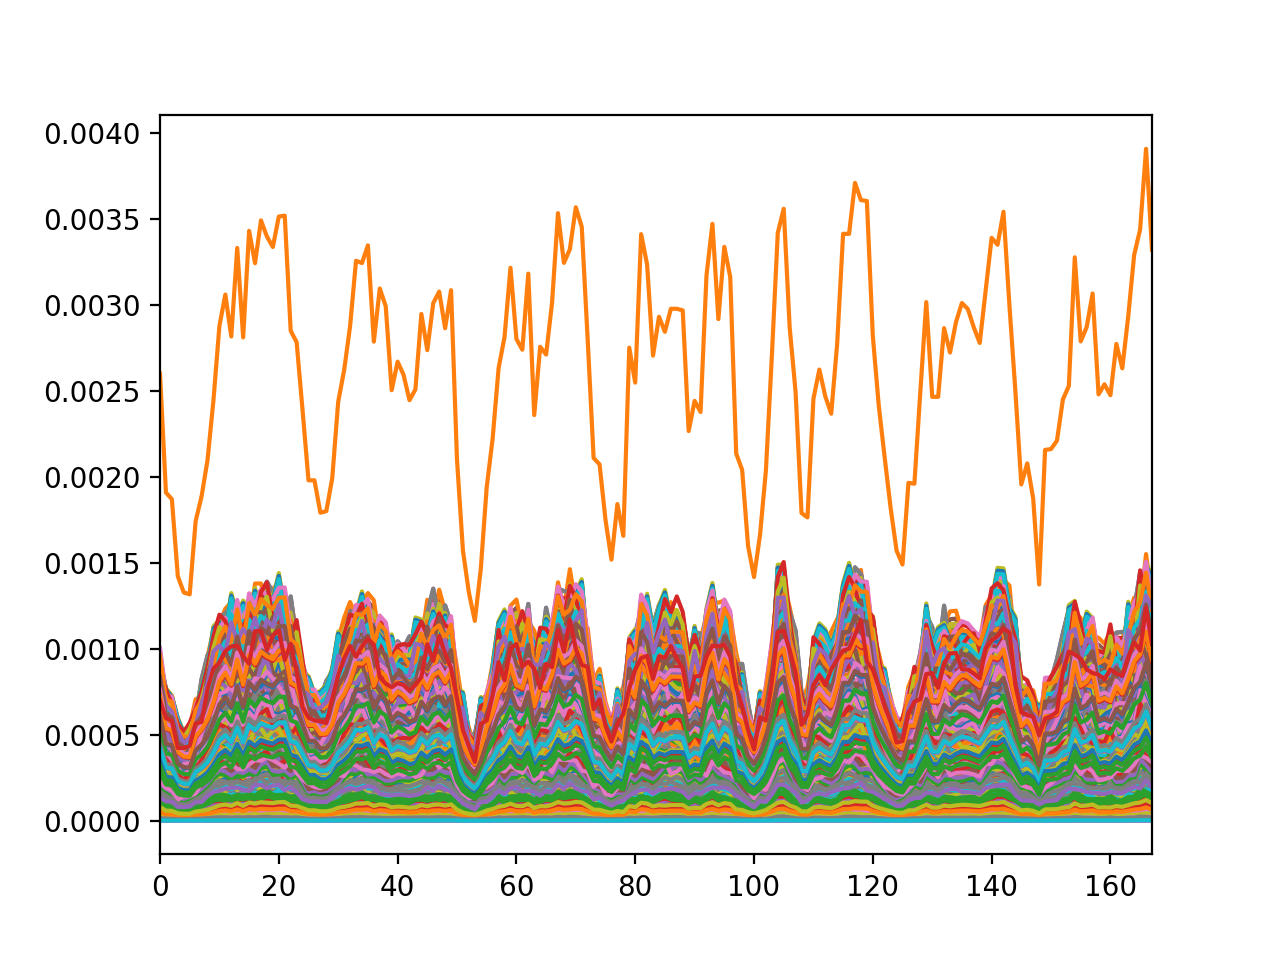

In [4]:
# Get and display demand patterns
df_pat = pd.DataFrame(columns = ctown.wn.junction_name_list)
for name, j in ctown.wn.junctions():
   base = j.demand_timeseries_list[0].base_value
   pat = j.demand_timeseries_list[0].pattern
   if pat is not None:
       df_pat.loc[:,name] = base * j.demand_timeseries_list[0].pattern.multipliers

#get nodes with base-demand > 0
d_juncs = df_pat.dropna(axis=1).columns

#display demand patterns
df_pat.plot(legend=None)
plt.show()

In [5]:
# Varying demand patterns
# Scaling
random.seed(3)
ctown.randomlyScaleMultipliers(0.1)  # Input is the maximum possible percentage of change for each pattern value

# Shifting
ctown.randomlyShiftMultipliers(3)  # Input is the maximum time shift allowed (in hours)

# ::::: SAVE seed

<IPython.core.display.Javascript object>


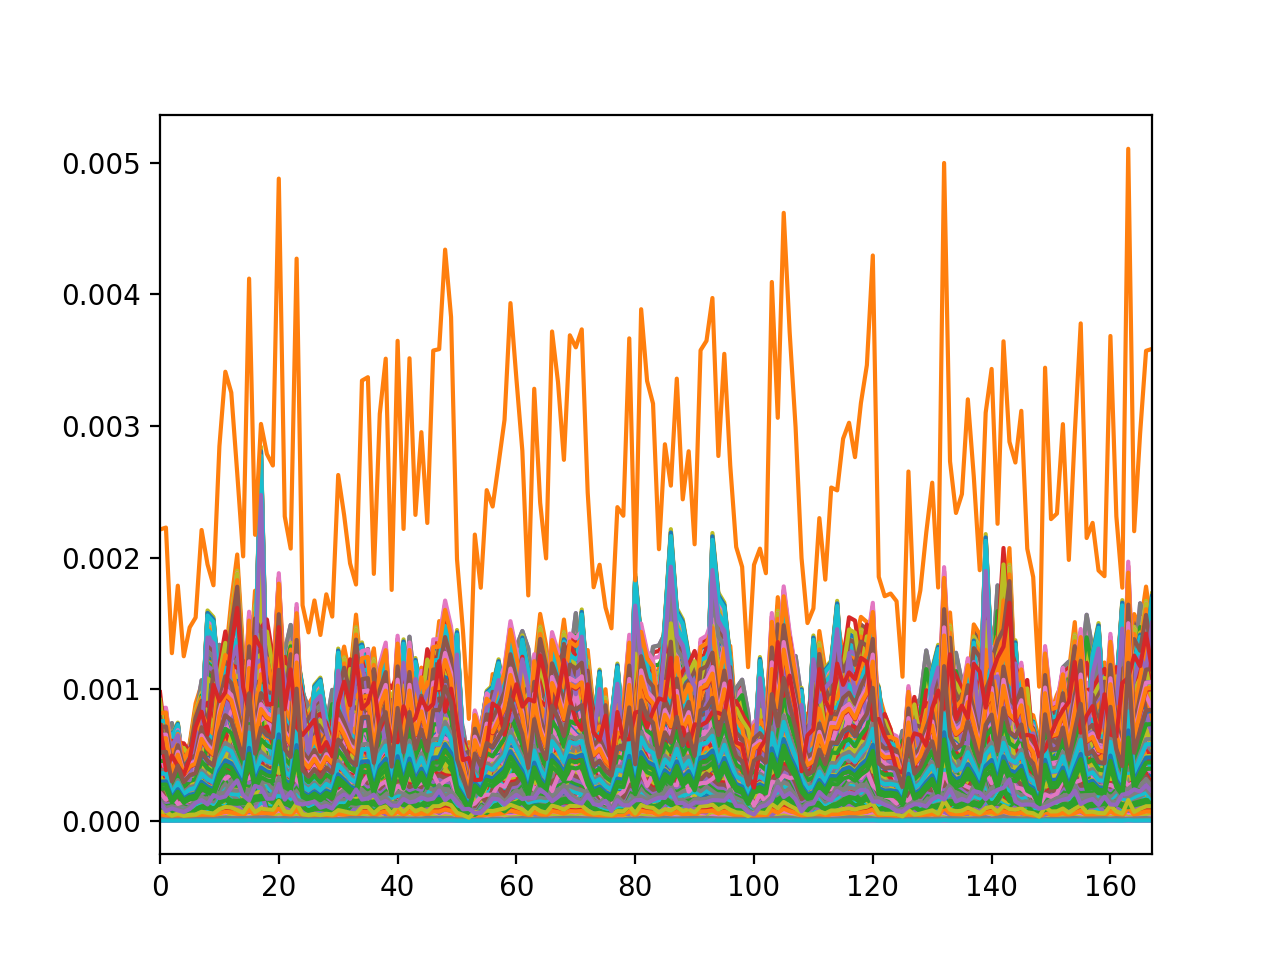

In [6]:
# Representing modified demand patterns
df_pat = pd.DataFrame(columns = ctown.wn.junction_name_list)
for name, j in ctown.wn.junctions():
   base = j.demand_timeseries_list[0].base_value
   pat = j.demand_timeseries_list[0].pattern
   if pat is not None:
       df_pat.loc[:,name] = base * j.demand_timeseries_list[0].pattern.multipliers

# get nodes with base-demand > 0
d_juncs = df_pat.dropna(axis=1).columns

# display demand patterns
df_pat.plot(legend=None)
plt.show()

# Run simulation

In [7]:
nDaysSim = 7
nHoursSim = 24*nDaysSim

# Getting tank elevations
tankEl =[]
for i, name in ctown.wn.tanks():
    tankEl.append(name.elevation)
np.array(tankEl)
nodeNames = ctown.getNodeName()

# wn.options.time.duration = 3600*24*nDaysSim#*nYearsSim
ctown.wn.options.time.hydraulic_timestep = 60*15  # 15 min
ctown.wn.options.time.quality_timestep = 60*15  # 15 min
ctown.wn.options.time.report_timestep = 60*15
ctown.wn.options.quality.mode = 'AGE'
ctown.wn.options.results.energystr = True

# TODO: Add controls
#ctown.addControls('V45', 'setting', 10., 'T4', '<', 3, 'user_added_1')
#ctown.addControls('V45', 'setting', 40., 'T4', '>', 4, 'user_added_2')


# ::: Adding controls
control_components = ctown.wn.pump_name_list + ctown.wn.valve_name_list
control_vector = np.array([ 0., 1., 1., 1., 1., 40., 40., 40., 0.])
min_control = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.]) # Lower bondary for controls
max_control = np.array([2., 2., 2., 2., 2., 600.0, 600.0, 600.0, 70. ]) # Upper bondary for contrrols

# Upper bound for minor loss coefficient set to 70 for Throttle Control Valves (TCV) according to https://en.wikipedia.org/wiki/Minor_losses_in_pipe_flow.
# Upper bound for pressure setting of PRV set to 600 according to (see DN 400): https://www.mankenberg.de/en/20/prgb:1/product:pressure-reducing-valves/products.html
control_vector_constraints = np.maximum(min_control, np.minimum(control_vector, max_control))

# ::: Running the simulation
start_time = time.time()

for i in range(nHoursSim):
    # Add controls
    for j in range(len(control_components)):
        currComp = ctown.wn.get_link(control_components[j])
        
        cond = controls.SimTimeCondition(ctown.wn, None,i*3600)
        act = controls.ControlAction(currComp, 'setting', control_vector_constraints[j])
        ctrl = controls.Control(cond,act, name=control_components[j])
        if np.isin(control_components[j], ctown.wn.control_name_list):
            ctown.wn.remove_control(control_components[j])
        ctown.wn.add_control(control_components[j], ctrl)
        ctown.wn.get_control(control_components[j])

    # Run the simulation for the next time step
    ctown.wn.options.time.duration = 3600*i
    sim = wntr.sim.EpanetSimulator(ctown.wn)
    results = sim.run_sim()
    results.tankElevations = results.node['head'][nodeNames[0]]-tankEl

print('Total simulation time: %.3f s' % (time.time()-start_time))
with open("results_sim.pkl", "wb") as f:
    pickle.dump(results, f)

Total simulation time: 52.492 s


<IPython.core.display.Javascript object>


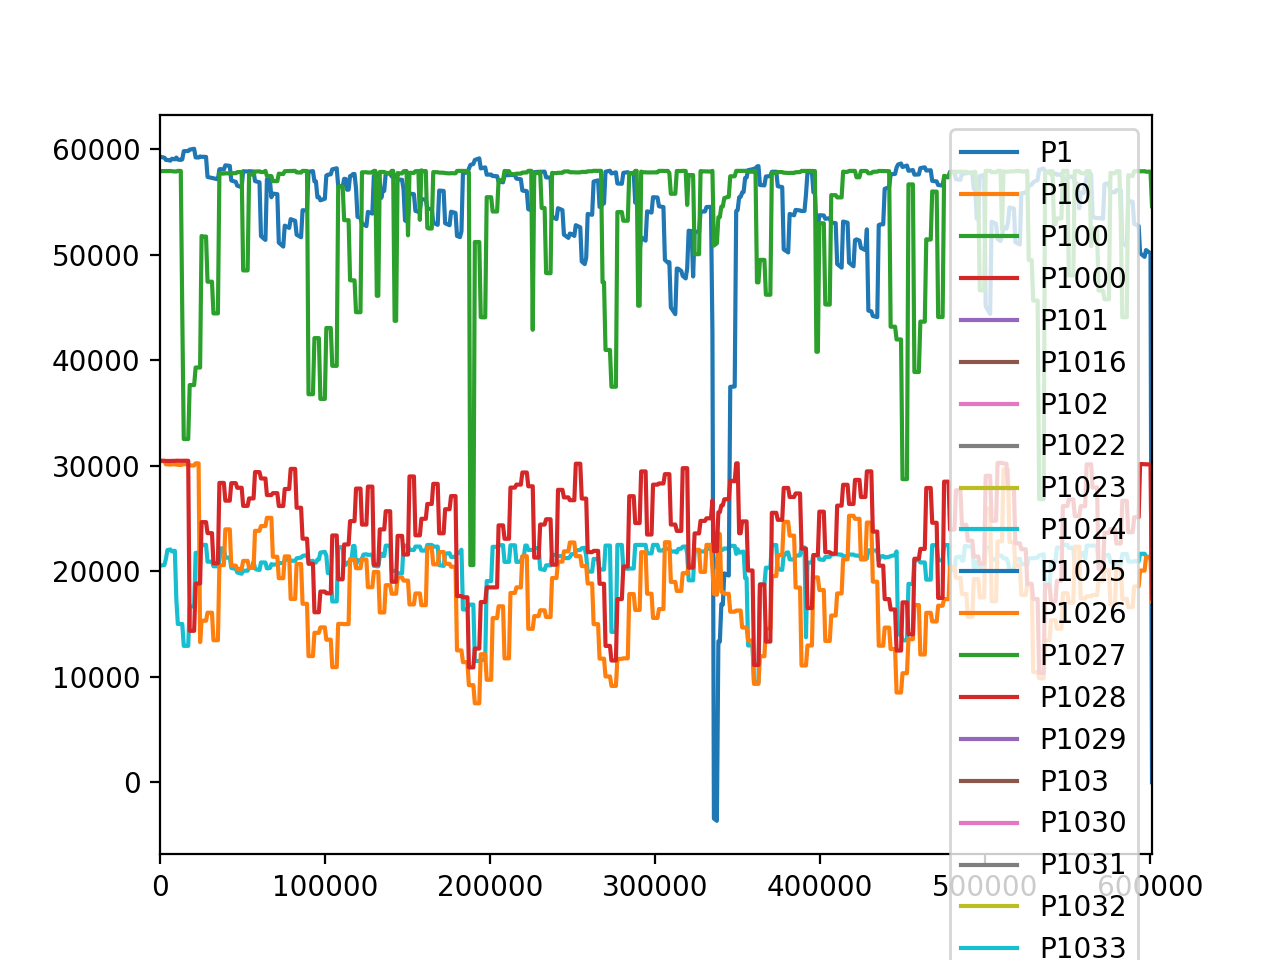

In [8]:
energy = economics.pump_energy(results.link['flowrate'], results.node['head'], ctown.wn)
plt.rcParams.update({'font.size': 10})
energy.plot()
plt.show()


In [9]:
energy

,P1,P10,P100,P1000,P101,P1016,P102,P1022,P1023,P1024,...,P999,PU10,PU2,PU5,PU6,PU8,V1,V2,V45,V47
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,20539.627511,59307.148438,30449.266183,57940.340402,30484.388951,NaN,NaN,NaN,NaN
900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,20561.301618,59275.362723,30446.992188,57942.293527,30483.688616,NaN,NaN,NaN,NaN
1800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,20582.717634,59242.974330,30444.626116,57944.157366,30482.681362,NaN,NaN,NaN,NaN
2700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,20603.888114,59210.881696,30442.154018,57945.965402,30481.425781,NaN,NaN,NaN,NaN
3600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21191.983817,58999.174107,30145.078125,57945.446429,30460.184152,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21397.101004,50457.025670,21340.926339,57883.861607,30150.415737,NaN,NaN,NaN,NaN
598500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21380.739397,50351.595982,21340.926339,57886.194196,30142.318638,NaN,NaN,NaN,NaN
599400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21366.439732,50246.261161,21340.926339,57887.578125,30134.215960,NaN,NaN,NaN,NaN
600300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,21352.084263,50141.132812,21340.926339,57888.939732,30126.071429,NaN,NaN,NaN,NaN


In [ ]:
fig_5, ax_5 = plt.subplots(11,1, sharex=True)
ax_5[0].plot(results.link['setting']['V45'])
ax_5[1].plot(results.node['pressure']['J253']-results.node['pressure']['J130'])
ax_5[2].plot(results.link['flowrate']['V45'])
ax_5[3].plot(results.link['setting']['V45'])
ax_5[4].plot(results.link['setting']['V1'])
ax_5[5].plot(results.link['setting']['V47'])
ax_5[6].plot(results.link['setting']['V2'])
ax_5[7].plot(results.link['status']['V45'])
ax_5[8].plot(results.link['status']['V1'])
ax_5[9].plot(results.link['status']['V47'])
ax_5[10].plot(results.link['status']['V2'])

plt.show()

In [ ]:
plt.plot(results.node['pressure'])
plt.show()